# CCKS2022基于知识图谱的优质文章识别 

本任务要求参赛者利用文章的知识图谱进行建模，实现优质文章分类。

赛题地址：[点击直达](https://aistudio.baidu.com/aistudio/competition/detail/255/0/introduction)


**赛题背景**

在移动互联网、大数据的时代背景下，各类自媒体文章呈爆发式增长，在搜索和推荐等信息分发场景下，甄别出优质文章并分发给用户具有重要的研究意义和实际应用价值。除了文章本身的写作质量以外，优质文章应该具备内容的深度和新颖性等，因此单纯依赖文章本身内容无法完整识别优质文章。本任务将引入文章相关的外部知识图谱，结合文章内在的知识逻辑，在对文章更深入的语义理解基础上实现优质文章识别。

**赛题说明**

本任务要求参赛者利用文章的知识图谱进行建模，实现优质文章分类。
输入数据示例如下：
```python
{
    "url": "http://baijiahao.baidu.com/s?id=1657091325677517018",
    "title": "新年首秀！美联储维持利率不变，中国央行或仍“淡定”",
    "pub_time": "2020-01-30",
    "content": "中新经纬客户端1月30日电 (张澍楠)在结束为期两天的货币政策例会后，美联储今日(30日)凌晨宣布，维持联邦基金利率在1.50%-1.75%不变，符合市场预期。<br/>“按兵不动”成共识...",
    "entities":{
        "联邦基金利率": {
            "co-occurrence": ["美国"], 
            "entity_id": "7949986", 
            "entity_baike_url": "https://baike.baidu.com/item/%E8%81%94%E9%82%A6%E5%9F%BA%E9%87%91%E5%88%A9%E7%8E%87/7949986", 
            "entity_baike_info": [
                {"name": "中文名", "value": ["联邦基金利率"]}, 
                {"name": "外文名", "value": ["Federal Funds Rate"]}, 
                {"name": "最主要的", "value": ["隔夜拆借利率"]}, 
                {"name": "投资", "value": ["国民经济"]}, 
                {"name": "释义", "value": ["美国同业拆借市场的利率，其最主要的是隔夜拆借利率"]}, 
                {"name": "反映", "value": ["反映银行之间资金的余缺"]}
            ]
        }
        "国际货币基金组织": ...
        "美国": ...
        ...
    }
}
```

各字段说明：

|字段|说明|
|---|---|
|url|文章链接|
|title|文章标题|
|pub_time|文章发布时间|
|content|文章内容，段落之间用<br/>分割|
|entities|文章中的实体集合|
|co-occurrence|文章中与当前实体在百科页面共现的实体集合|
|entity_id|实体id|
|entity_baike_url|实体百度百科链接|
|entity_baike_info|实体百度百科信息|

<br>

输出示例如下：

```python
{
    "url": "http://baijiahao.baidu.com/s?id=1657091325677517018",
    "label": 0
}
```
各字段说明：

|字段|说明|
|---|---|
|url|文章链接|
|label|文章标签，0表示非优质文章，1表示优质文章|


**评价指标**

F1-Score

# Baseline思路

本赛题是经典的文本二分类任务，难点在于如何融入知识图谱的三元组信息辅助文章质量的判断，根据赛题特点，有两方面考虑。
- 在预训练模型选择上，选择百度的**ERNIE-1.0**，ERNIE-1.0改进了两种masking 策略，一种是基于phrase的masking策略，另外一种是基于entity的masking策略。在ERNIE 当中，将由多个字组成的phrase或者entity当成一个统一单元，相比于bert基于字的mask, 这个单元当中的的所有字在训练的时候，统一被mask. 对比直接将知识类的query 映射成向量然后直接加起来，ERNIE 通过统一mask的方式可以潜在的学习到知识的依赖以及更长的语义依赖来让模型更具泛化性。

- 在输入数据构造上，受预训练模型输入长度的限制，测试了四种不同组合的输入方式：
    - 方案一：仅使用标题（最大截断长度 50）
    - 方案二：标题 + 正文截断（最大截断长度 256/512）
    - 方案二：使用标题拼接文章的实体信息，以SEP分隔（最大截断长度 250）
    - 方案三：使用标题拼接文章的正文段落（通过相似度召回topk个限制长度的段落），以SEP分隔（最大截断长度 512）

## Baseline效果

|model|输入方式|验证分数|线上分数|
|---|---|---|---|
|ernie-1.0-base-zh|仅标题-50|0.806122|0.762|
|ernie-1.0-base-zh|标题 + 正文截断-256|0.817602|0.815|
|ernie-1.0-base-zh|标题 + 正文截断-512|0.821429|0.800|
|ernie-1.0-base-zh|标题 + 实体信息-250|0.917092|0.766|
|ernie-1.0-base-zh|标题 + 正文段落-512|0.813776|0.804|
|ernie-3.0-base-zh|标题 + 正文截断-256|0.79719|0.823|

baseline实验结果：
- 仅使用标题的baseline是效果最差的
- 三种拼接方法（直接截断正文、拼接实体信息、拼接topk相似段落）都有一定程度的增益效果，其中直接截断正文（最大截断长度 256）效果最好，说明正文中蕴含大量能够提升模型性能的可用信息。
- 拼接实体信息会导致模型过拟合，虽然验证分数很高，但线上的分数有明显差距，出现严重过拟合现象，可能的猜测是直接拼接大量实体信息会破坏句子结构和完整性。
- 采用实体信息检索topk个正文相关段落也是较为有效的方法，baseline采用的检索方式较为简单，后续可以优化检索的方式和提高检索段落和三元组信息之间的相关性。
- 使用留一法划分训练集和验证集时，线下验证分数和线上分数具有明显差异，建议后续可以使kfold多折交叉验证方式进行优化

此外，除了在ernie-1.0上开展baseline实验，新上线的融合大规模知识的预训练模型ERNIE3.0可能会有更好地效果，在上述效果最好的输入构造上进行实验（标题 + 正文截断-256）得到了0.823线上分数超过了ernie-1.0。

故最终使用ernie-3.0-base-zh和标题 + 正文截断-256 作为baseline方案，得到线下0.823

## 后续优化推荐

- 考虑直接对长文本内容进行建模，可以选择ernie-doc模型
- 正文段落包含大量可学习信息，使用段落匹配+拼接的方式，显式引入额外信息
- 使用TransE等Knowledge Graph Embedding方法，隐式引入三元组信息
- 使用FGM、PGD等对抗训练方法，提高模型的鲁棒性




In [ ]:
# 更新paddlenlp
!pip install -U paddlenlp

In [2]:
import os
# 解压数据集
if not os.path.exists("train.json"):
    # print('aaa')
    !unzip -d data/ data148680/train.json.zip
    !unzip -d data/ data148680/val.unlabel.json.zip

'unzip' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���
'unzip' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


# 具体方案

In [ ]:
!pip install seaborn

In [9]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import paddle
import paddlenlp
import time
import paddle.nn.functional as F
from functools import partial
from paddlenlp.data import Stack, Dict, Pad
from paddlenlp.datasets import load_dataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

seed = 42
def set_seed(seed):
    paddle.seed(seed)
    random.seed(seed)
    np.random.seed(seed)
set_seed(seed)


## 1 数据读取

In [11]:
# 数据读取
def read_json(file_name):
    examples = []
    with open(file_name,"r",encoding="utf-8") as f:
        for i in f.readlines():
            examples.append(json.loads(i))
    return examples

train = read_json("data/train.json")
test = read_json("data/val.unlabel.json")
print("train size:",len(train))
print("test size:",len(test))

train size: 7835
test size: 1078



## 2 EDA简单数据分析

已生成缓存文件

若要更改参数，请到work删除states_train.csv和states_test.csv文件，重新运行下方cell程序

通过暴力检索相似段落需要耗费时间（约30分钟）

In [12]:
# 由于计算相似度需要时间，生成缓存文件方便读写
if os.path.exists('work/states_train.csv') and os.path.exists('work/states_test.csv'):
    states_train = pd.read_csv("work/states_train.csv")
    states_test = pd.read_csv("work/states_test.csv")
else:
    # 使用Taskflow可以一键预测句子相似度
    from paddlenlp.taskflow import Taskflow
    similarity_model = Taskflow("text_similarity")
    # 设置召回数量，控制召回段落最大最小长度
    topk = 3
    min_content_length = 32
    max_content_length = 256
    # 统计指标
    states_train = pd.DataFrame(train)
    states_train['title_len'] = [len(i) for i in states_train['title']]
    states_train['content_len'] = [len(i) for i in states_train['content']]
    states_train['entities_num'] = [len(i) for i in states_train['entities']]

    states_test = pd.DataFrame(test)
    states_test['title_len'] = [len(i) for i in states_test['title']]
    states_test['content_len'] = [len(i) for i in states_test['content']]
    states_test['entities_num'] = [len(i) for i in states_test['entities']]

    states_train['concat_entities'] = [rows['pub_time']+'[SEP]'+rows['title']+'[SEP]'+'关键信息：'+",".join(rows['entities']) for idx,rows in states_train.iterrows()]
    states_test['concat_entities'] = [rows['pub_time']+'[SEP]'+rows['title']+'[SEP]'+'关键信息：'+",".join(rows['entities']) for idx,rows in states_test.iterrows()]
    states_train['concat_len'] = [len(i) for i in states_train['concat_entities']]
    states_test['concat_len'] = [len(i) for i in states_test['concat_entities']]

    # 生成检索句子
    def retrieve_sentence(similarity_pair,topk=topk):
        similarity_list = pd.DataFrame(similarity_model(similarity_pair))
        similarity_list.sort_values(by="similarity",ascending=False,inplace=True)
        return ",".join(similarity_list['text1'][:topk])

    # 训练集
    for idx,rows in tqdm(states_train.iterrows(),total=states_train.shape[0]):
        doc_lists = [d for d in rows['content'].split('<br/>') if len(d) > min_content_length and len(d) < max_content_length] 
        entitie_info = []
        for k in rows['entities'].keys():
            entitie_info.extend(rows['entities'][k]['co-occurrence']+[k])
        entitie_info = list(set(entitie_info))
        similarity_pair = [[s1," ".join(entitie_info)] for s1 in doc_lists]
        if similarity_pair:
            states_train.loc[idx,'concat_content'] =  rows['title'] + '[SEP]' + retrieve_sentence(similarity_pair,topk=topk)
        else:
            states_train.loc[idx,'concat_content'] =  rows['title']
    # 测试集
    for idx,rows in tqdm(states_test.iterrows(),total=states_test.shape[0]):
        doc_lists = [d for d in rows['content'].split('<br/>') if len(d) > min_content_length and len(d) < max_content_length] 
        entitie_info = []
        for k in rows['entities'].keys():
            entitie_info.extend(rows['entities'][k]['co-occurrence']+[k])
        entitie_info = list(set(entitie_info))
        similarity_pair = [[s1," ".join(entitie_info)] for s1 in doc_lists]
        if similarity_pair:
            states_test.loc[idx,'concat_content'] =  rows['title'] + '[SEP]' + retrieve_sentence(similarity_pair,topk=topk)
        else:
            states_test.loc[idx,'concat_content'] =  rows['title']
    states_train['concat_content_len'] = [len(i) for i in states_train['concat_content']]
    states_test['concat_content_len'] = [len(i) for i in states_test['concat_content']]

    states_train.to_csv("work/states_train.csv",index=False)
    states_test.to_csv("work/states_test.csv",index=False)

### 2.1 文本长度

49.0


C:\Users\kitx86\AppData\Local\Temp\ipykernel_14440\2582958495.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(states_train['title_len'],bins=10,color='r')
C:\Users\kitx86\AppData\Local\Temp\ipykernel_14440\2582958495.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(states_test['title_len'

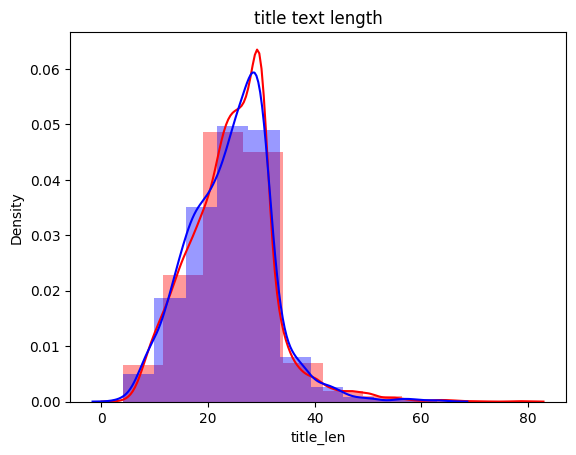

In [13]:
plt.title("title text length")
print(states_train['title_len'].quantile(0.99))
sns.distplot(states_train['title_len'],bins=10,color='r')
sns.distplot(states_test['title_len'],bins=10,color='b')
plt.show()

1306.68


C:\Users\kitx86\AppData\Local\Temp\ipykernel_14440\1343387967.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(states_train['content_len'],bins=10,color='r')
C:\Users\kitx86\AppData\Local\Temp\ipykernel_14440\1343387967.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(states_test['content_

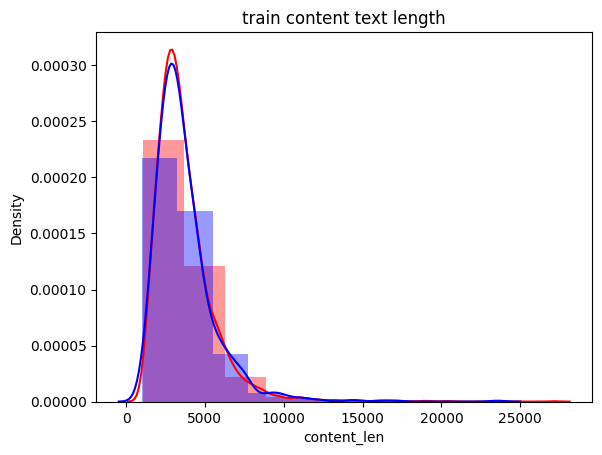

In [14]:
plt.title("train content text length")
print(states_train['content_len'].quantile(0.01))
sns.distplot(states_train['content_len'],bins=10,color='r')
sns.distplot(states_test['content_len'],bins=10,color='b')
plt.show()


### 2.2 实体个数

48.0


C:\Users\kitx86\AppData\Local\Temp\ipykernel_14440\3022338940.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(states_train['entities_num'],bins=10,color='r')
C:\Users\kitx86\AppData\Local\Temp\ipykernel_14440\3022338940.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(states_test['entitie

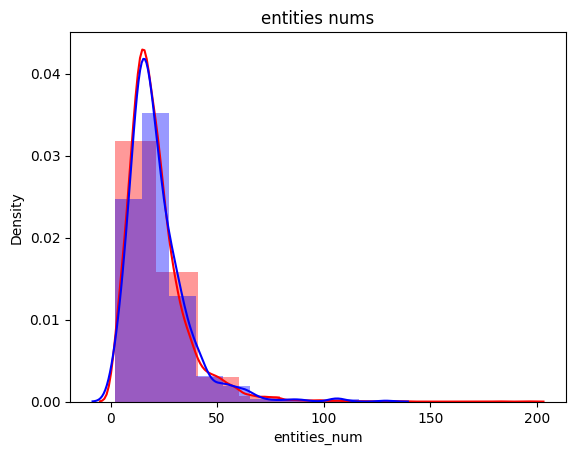

In [15]:
plt.title("entities nums")
print(states_train['entities_num'].quantile(0.95))
sns.distplot(states_train['entities_num'],bins=10,color='r')
sns.distplot(states_test['entities_num'],bins=10,color='b')
plt.show()

### 2.3 标签分布

label
0    4932
1    2903
Name: count, dtype: int64


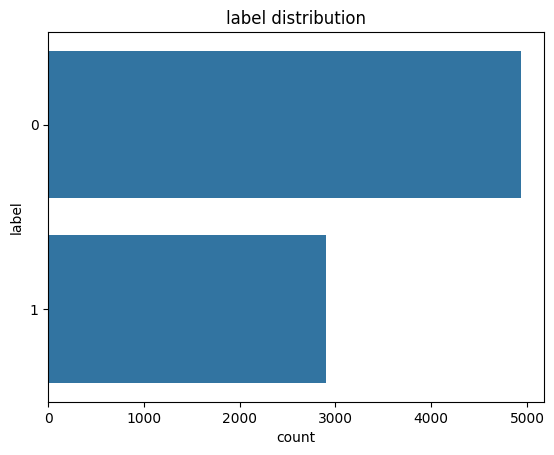

In [16]:
print(states_train['label'].value_counts())
plt.title("label distribution")
sns.countplot(y='label',data=states_train)
plt.show()

### 2.4 拼接实体信息

简单将标题和实体信息进行拼接

243.29999999999927


C:\Users\kitx86\AppData\Local\Temp\ipykernel_14440\4000614750.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(states_train['concat_len'],bins=10,color='r')
C:\Users\kitx86\AppData\Local\Temp\ipykernel_14440\4000614750.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(states_test['concat_le

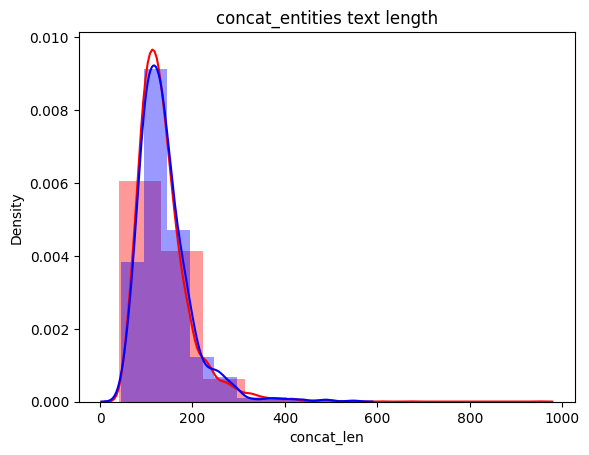

In [17]:
plt.title("concat_entities text length")
print(states_train['concat_len'].quantile(0.95))
sns.distplot(states_train['concat_len'],bins=10,color='r')
sns.distplot(states_test['concat_len'],bins=10,color='b')
plt.show()

### 2.5 拼接Topk个正文段落

通过相似度模型检索topk个相关正文段落，并进行文本长度统计

596.0


C:\Users\kitx86\AppData\Local\Temp\ipykernel_14440\4088683616.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(states_train['concat_content_len'],bins=10,color='r')
C:\Users\kitx86\AppData\Local\Temp\ipykernel_14440\4088683616.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(states_test['c

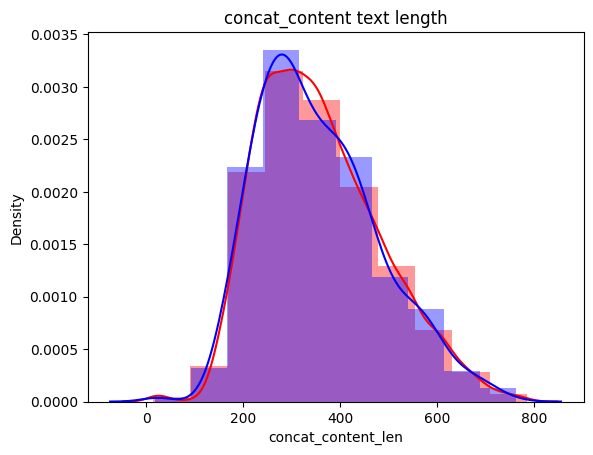

In [18]:
plt.title("concat_content text length")
print(states_train['concat_content_len'].quantile(0.95))
sns.distplot(states_train['concat_content_len'],bins=10,color='r')
sns.distplot(states_test['concat_content_len'],bins=10,color='b')
plt.show()

### 2.4 EDA总结

- 文本标题长度最大不超过80字，大多（99%）在50字以下，正文的文本长度大部分超过千字。
- 实体个数上看，大部分（95%）不超过48个实体。
- 标签分布上看，优质文章(2903)比非优质文章(4932)更少,存在不平衡情况。
- 此外还统计了拼接实体和拼接检索topk正文段落的句子长度，便于后续设置最大截断长度。

针对EDA中的情况，主要采用以下四种策略：
- 仅标题（最大截断长度 50）
- 标题 + 正文直接截断（最大截断长度 256 / 512）
- 标题 + 实体信息（最大截断长度 250）
- 标题 + Topk个正文段落（由实体信息相似度计算得到）（最大截断长度 512）

# 3 数据处理

In [19]:
from paddlenlp.transformers.bert.tokenizer import BertTokenizer
from paddlenlp.transformers.ernie.tokenizer import ErnieTokenizer

# 查看可使用的ernie模型
ErnieTokenizer.pretrained_resource_files_map['vocab_file'].keys()

dict_keys(['ernie-1.0', 'ernie-1.0-base-zh', 'ernie-1.0-base-zh-cw', 'ernie-1.0-large-zh-cw', 'ernie-tiny', 'ernie-2.0-base-zh', 'ernie-2.0-large-zh', 'ernie-2.0-base-en', 'ernie-2.0-base-en-finetuned-squad', 'ernie-2.0-large-en', 'ernie-gen-base-en', 'ernie-gen-large-en', 'ernie-gen-large-en-430g', 'rocketqa-zh-dureader-query-encoder', 'rocketqa-zh-dureader-para-encoder', 'rocketqa-v1-marco-query-encoder', 'rocketqa-v1-marco-para-encoder', 'rocketqa-zh-dureader-cross-encoder', 'rocketqa-v1-marco-cross-encoder', 'ernie-3.0-base-zh', 'ernie-3.0-xbase-zh', 'ernie-3.0-medium-zh', 'ernie-3.0-mini-zh', 'ernie-3.0-micro-zh', 'ernie-3.0-nano-zh', 'ernie-3.0-tiny-base-v1-zh', 'ernie-3.0-tiny-medium-v1-zh', 'ernie-3.0-tiny-mini-v1-zh', 'ernie-3.0-tiny-micro-v1-zh', 'ernie-3.0-tiny-nano-v1-zh', 'rocketqa-zh-base-query-encoder', 'rocketqa-zh-base-para-encoder', 'rocketqa-zh-medium-query-encoder', 'rocketqa-zh-medium-para-encoder', 'rocketqa-zh-mini-query-encoder', 'rocketqa-zh-mini-para-encoder',

In [24]:
# 加载tokenizer
# ernie-1.0-base-zh / ernie-2.0-base-zh / ernie-3.0-base-zh
MODEL_NAME = "ernie-3.0-base-zh" 
tokenizer = ErnieTokenizer.from_pretrained(MODEL_NAME)

[2024-06-09 17:20:23,556] [    INFO] - Already cached C:\Users\kitx86\.paddlenlp\models\ernie-3.0-base-zh\ernie_3.0_base_zh_vocab.txt
[2024-06-09 17:20:23,577] [    INFO] - tokenizer config file saved in C:\Users\kitx86\.paddlenlp\models\ernie-3.0-base-zh\tokenizer_config.json
[2024-06-09 17:20:23,577] [    INFO] - Special tokens file saved in C:\Users\kitx86\.paddlenlp\models\ernie-3.0-base-zh\special_tokens_map.json


In [21]:
# 设置超参数
max_seq_length = 256  # 50(title) /  256(title+content)  / 512(title+content) / 250(title+entity) / 512(title+sim_content)
train_batch_size = 32
valid_batch_size = 16
test_batch_size = 8

# 切分数据集，按照9:1划分训练集和验证集
train_ds,valid_ds = train_test_split(states_train,test_size=0.1,random_state=seed)

# 生成数据集
# 拼接标题、实体字段，每个字段以SEP间隔,实体名称之间按'，'分隔
def read(df,istrain=True):
    if istrain:
        for idx,rows in df.iterrows():
            # words = rows['title']
            words = rows['title'] + '[SEP]' + rows['content'] 
            # words = rows['concat_entities']
            # words = rows['concat_content'] 
            yield{
                "words":words,
                "labels":rows['label']
                }
    else:
        for idx,rows in df.iterrows():
            # words = rows['title']
            words = rows['title'] + '[SEP]' + rows['content'] 
            # words = rows['concat_entities']
            # words = rows['concat_content'] 
            yield {
                "words":words,
                }

# 将生成器传入load_dataset
train_ds = load_dataset(read, df=train_ds, lazy=False)
valid_ds = load_dataset(read, df=valid_ds, lazy=False)

# 编码
def convert_example(example, tokenizer, max_seq_len=512, mode='train'):
    # 调用tokenizer的数据处理方法把文本转为id
    tokenized_input = tokenizer(
        example['words'],
        is_split_into_words=True,
        max_seq_len=max_seq_len)
    if mode == "test":
        return tokenized_input
    # 把意图标签转为数字id
    tokenized_input['labels'] = [example['labels']]
    return tokenized_input

train_trans_func = partial(
        convert_example,
        tokenizer=tokenizer,
        mode='train',
        max_seq_len=max_seq_length)

valid_trans_func = partial(
        convert_example,
        tokenizer=tokenizer,
        mode='dev',
        max_seq_len=max_seq_length)

train_ds.map(train_trans_func)
valid_ds.map(valid_trans_func)

# 初始化BatchSampler
np.random.seed(seed)
train_batch_sampler = paddle.io.BatchSampler(train_ds, batch_size=train_batch_size, shuffle=True)
valid_batch_sampler = paddle.io.BatchSampler(valid_ds, batch_size=valid_batch_size, shuffle=False)

# 定义batchify_fn
batchify_fn = lambda samples, fn = Dict({
    "input_ids": Pad(axis=0, pad_val=tokenizer.pad_token_id), 
    "token_type_ids": Pad(axis=0, pad_val=tokenizer.pad_token_type_id),
    "labels": Stack(dtype="int64"),
}): fn(samples)

# 初始化DataLoader
train_data_loader = paddle.io.DataLoader(
    dataset=train_ds,
    batch_sampler=train_batch_sampler,
    collate_fn=batchify_fn)

valid_data_loader = paddle.io.DataLoader(
    dataset=valid_ds,
    batch_sampler=valid_batch_sampler,
    collate_fn=batchify_fn)

# 4 模型搭建

In [27]:
import paddle
from paddle import nn
from paddlenlp.transformers.ernie.modeling import ErniePretrainedModel
# Ernie
class ErnieForModel(ErniePretrainedModel):
    def __init__(self, ernie, num_classes=None, dropout=None):
        super().__init__()
        # 预训练模型
        self.ernie = ernie
        self.num_classes = num_classes 
        self.dropout = nn.Dropout(self.ernie.config['hidden_dropout_prob'])
        self.classifier = nn.Linear(self.ernie.config['hidden_size'], self.num_classes)
        self.apply(self.init_weights)

    def forward(self,input_ids,token_type_ids=None, layer_mode=None):
        sequence_output , pooled_output = self.ernie(input_ids,token_type_ids=token_type_ids)
        if layer_mode is None:
            output = sequence_output.mean(axis=1)
        elif layer_mode == "cls_pooling":
            output = pooled_output
        elif layer_mode == "mean_pooling":
            output = sequence_output.mean(axis=1)
        output = self.dropout(output) 
        logits = self.classifier(output)
        return logits

model = ErnieForModel.from_pretrained(MODEL_NAME,num_classes=2)

[2024-06-09 17:22:29,849] [    INFO] - Already cached C:\Users\kitx86\.paddlenlp\models\ernie-3.0-base-zh\model_state.pdparams
[2024-06-09 17:22:29,849] [    INFO] - Loading weights file model_state.pdparams from cache at C:\Users\kitx86\.paddlenlp\models\ernie-3.0-base-zh\model_state.pdparams
[2024-06-09 17:22:30,139] [    INFO] - Loaded weights file from disk, setting weights to model.


ValueError: PretrainedConfig instance not found in the arguments, you can set it as args or kwargs with config field

# 5 模型配置

In [16]:
# 训练过程中的最大学习率
learning_rate = 5e-5
# 训练轮次
epochs = 4
# 学习率预热比例
warmup_proportion = 0.1
# 权重衰减系数，类似模型正则项策略，避免模型过拟合
weight_decay = 0.01
max_grad_norm = 1.0
# 训练结束后，存储模型参数
save_dir_curr = "checkpoint/model"
# 记录训练epoch、损失等值
loggiing_print = 10
loggiing_eval = 50

# 训练总步数
num_training_steps = len(train_data_loader) * epochs

# 学习率衰减策略
lr_scheduler = paddlenlp.transformers.LinearDecayWithWarmup(learning_rate, num_training_steps,warmup_proportion)

decay_params = [
    p.name for n, p in model.named_parameters()
    if not any(nd in n for nd in ["bias", "norm"])
]

# 定义AdamW优化器
optimizer = paddle.optimizer.AdamW(
    learning_rate=lr_scheduler,
    parameters=model.parameters(),
    weight_decay=weight_decay,
    apply_decay_param_fun=lambda x: x in decay_params,
    grad_clip=paddle.nn.ClipGradByGlobalNorm(max_grad_norm))
    
# 交叉熵损失函数
criterion = paddle.nn.loss.CrossEntropyLoss()

# 6 模型训练

In [17]:
# 验证部分
@paddle.no_grad()
def evaluation(model, data_loader):
    model.eval()
    real_s = []
    pred_s = []
    for batch in data_loader:
        input_ids, token_type_ids, labels = batch
        logits = model(input_ids, token_type_ids)
        probs = F.softmax(logits, axis=1)
        pred_s.extend(probs.argmax(axis=1).numpy())
        real_s.extend(labels.reshape([-1]).numpy())
    score =  f1_score(y_pred=pred_s,y_true=real_s,average='micro')
    print(classification_report(y_pred=pred_s,y_true=real_s))
    return score

# 训练阶段
def do_train(model,data_loader):
    tic_train = time.time()
    model_total_epochs = 0
    best_score = 0.
    training_loss = 0
    # 训练
    print("train ...")
    model.train()
    for epoch in range(0, epochs):
        for step, batch in enumerate(data_loader, start=1):
            input_ids, token_type_ids, labels = batch
            logits = model(input_ids, token_type_ids)
            # 计算损失函数值
            loss = criterion(logits, labels)
            # 预测分类概率值
            probs = F.softmax(logits, axis=1)
            score =  f1_score(probs.argmax(axis=1),labels.reshape([-1]),average='micro')
            model_total_epochs += 1
            if model_total_epochs % loggiing_print == 0:
                print("step: %d / %d, training loss: %.4f F1: %.4f speed: %.2f step/s" % (model_total_epochs, num_training_steps, loss.numpy(), score, (10 / (time.time() - tic_train))))
            
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.clear_grad()
            
            if model_total_epochs % loggiing_eval == 0:
                
                eval_score = evaluation(model, valid_data_loader)
                model.train()

                print("eval f1: %.5f best f1: %.5f " % (eval_score,best_score))
                if best_score  < eval_score:
                    print("F1 update %.5f ---> %.5f " % (best_score,eval_score))
                    best_score  = eval_score
                    # 保存模型
                    os.makedirs(save_dir_curr,exist_ok=True)
                    save_param_path = os.path.join(save_dir_curr, 'model_best.pdparams')
                    paddle.save(model.state_dict(), save_param_path)
                    # 保存tokenizer
                    tokenizer.save_pretrained(save_dir_curr)
            tic_train = time.time()

    return best_score

In [ ]:
best_score = do_train(model,train_data_loader)

In [ ]:
# logging part
logging_dir = 'work/logging_print'
logging_name = os.path.join(logging_dir,'run_logging.csv')
os.makedirs(logging_dir,exist_ok=True)

var = [seed, MODEL_NAME, learning_rate, max_seq_length, best_score]
names = ['seed', 'model', 'lr', "max_len" ,"best_f1"]
vars_dict = {k: v for k, v in zip(names, var)}
results = dict(**vars_dict)
keys = list(results.keys())
values = list(results.values())

if not os.path.exists(logging_name):    
    ori = []
    ori.append(values)
    logging_df = pd.DataFrame(ori, columns=keys)
    logging_df.to_csv(logging_name, index=False)
else:
    logging_df= pd.read_csv(logging_name)
    new = pd.DataFrame(results, index=[1])
    logging_df = logging_df.append(new, ignore_index=True)
    logging_df.to_csv(logging_name, index=False)  

print("best pearsonr score: %.5f" % best_score)
print(logging_df)

# 7 预测结果

In [22]:
# 相同方式构造测试集
test_ds = load_dataset(read,df=states_test, istrain=False, lazy=False)

test_trans_func = partial(
        convert_example,
        tokenizer=tokenizer,
        mode='test',
        max_seq_len=max_seq_length)

test_ds.map(test_trans_func, lazy=False)

test_batch_sampler = paddle.io.BatchSampler(test_ds, batch_size=test_batch_size, shuffle=False)

test_batchify_fn = lambda samples, fn = Dict({
    "input_ids": Pad(axis=0, pad_val=tokenizer.pad_token_id), 
    "token_type_ids": Pad(axis=0, pad_val=tokenizer.pad_token_type_id),
}): fn(samples)

test_data_loader = paddle.io.DataLoader(
    dataset=test_ds,
    batch_sampler=test_batch_sampler,
    collate_fn=test_batchify_fn,
    return_list=True)

# 预测阶段
def do_sample_predict(model,data_loader):
    model.eval()
    preds = []
    for batch in data_loader:
        input_ids, token_type_ids= batch
        logits = model(input_ids, token_type_ids)
        probs = F.softmax(logits, axis=1)
        preds.extend(probs.argmax(axis=1).numpy())
    return preds

# 读取最佳模型
state_dict = paddle.load(os.path.join(save_dir_curr,'model_best.pdparams'))
model.load_dict(state_dict)

# 预测
print("predict start ...")
preds = do_sample_predict(model,test_data_loader)
print("predict end ...")

predict start ...
predict end ...


In [23]:
pd.DataFrame(preds,columns=['pred']).value_counts()

pred
0       719
1       359
dtype: int64

# 生成提交文件

提交格式如下：
```
{
    "url": "http://baijiahao.baidu.com/s?id=1657091325677517018",
    "label": 0
}
```

文件需要以result.txt命名

In [24]:
# 提交文件名称
sumbit_name = "work/result.txt"
submit_data = []
for idx,item in enumerate(test):
    submit_data.append({'url':item["url"],"label":int(preds[idx])})
with open(sumbit_name,'w') as f:
    for line in submit_data:
        jsonData = json.dumps(line,ensure_ascii=False)
        f.write(jsonData + os.linesep)
print(f"已生成提交文件{sumbit_name}")

已生成提交文件work/result.txt
